<a href="https://colab.research.google.com/github/wojtekwalczak/neural_nets/blob/master/fashion_mnist_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
', '.join((i for i in dir(training_data) if not i.startswith('__')))


'_check_exists, _check_legacy_exist, _format_transform_repr, _load_data, _load_legacy_data, _repr_indent, class_to_idx, classes, data, download, extra_repr, functions, mirrors, processed_folder, raw_folder, register_datapipe_as_function, register_function, resources, root, target_transform, targets, test_data, test_file, test_labels, train, train_data, train_labels, training_file, transform, transforms'

In [7]:
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
training_data.data.shape

torch.Size([60000, 28, 28])

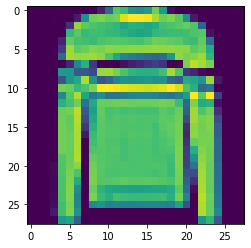

In [15]:
plt.imshow(training_data.data[5])
plt.show()

In [18]:
training_data.train_labels[:10]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [19]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [21]:
torch.cuda.is_available()

False

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [25]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308527  [    0/60000]
loss: 2.298336  [ 6400/60000]
loss: 2.280278  [12800/60000]
loss: 2.266307  [19200/60000]
loss: 2.247687  [25600/60000]
loss: 2.229595  [32000/60000]
loss: 2.221612  [38400/60000]
loss: 2.195329  [44800/60000]
loss: 2.183947  [51200/60000]
loss: 2.154964  [57600/60000]
Test Error: 
 Accuracy: 51.0%, Avg loss: 2.151932 

Epoch 2
-------------------------------
loss: 2.163084  [    0/60000]
loss: 2.155378  [ 6400/60000]
loss: 2.099721  [12800/60000]
loss: 2.110779  [19200/60000]
loss: 2.056201  [25600/60000]
loss: 2.007664  [32000/60000]
loss: 2.017362  [38400/60000]
loss: 1.947689  [44800/60000]
loss: 1.944664  [51200/60000]
loss: 1.871332  [57600/60000]
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.876162 

Epoch 3
-------------------------------
loss: 1.910862  [    0/60000]
loss: 1.878153  [ 6400/60000]
loss: 1.768177  [12800/60000]
loss: 1.800715  [19200/60000]
loss: 1.690734  [25600/60000]
loss: 1.658029  [32000/600